In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')

In [4]:
df.columns = ['KOUS']
df['KOUS'].replace('.', '', inplace=True)
df['KOUS'] = pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method='ffill', inplace=True)



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
KOUS    1306 non-null float64
dtypes: float64(1)
memory usage: 20.4 KB


In [7]:
df = df[(df.index>'2019-01-01')&(df.index<'2020-01-01')]

# ARIMA(p,k,q) => k 결정

In [8]:
adfuller(df.KOUS)

(-1.8342899250680114,
 0.36357542996557135,
 2,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1453.3457437081727)

- p-value : 0.36 이므로 크기때문에 안정적이지 않다



In [9]:
adfuller(df.KOUS.diff().dropna())
# k=1 1차 차분이 안정적이다.

(-10.57263252449283,
 7.239046680336976e-19,
 1,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1446.168602565303)

# ARIMA(p,k,q) => p, q 결정

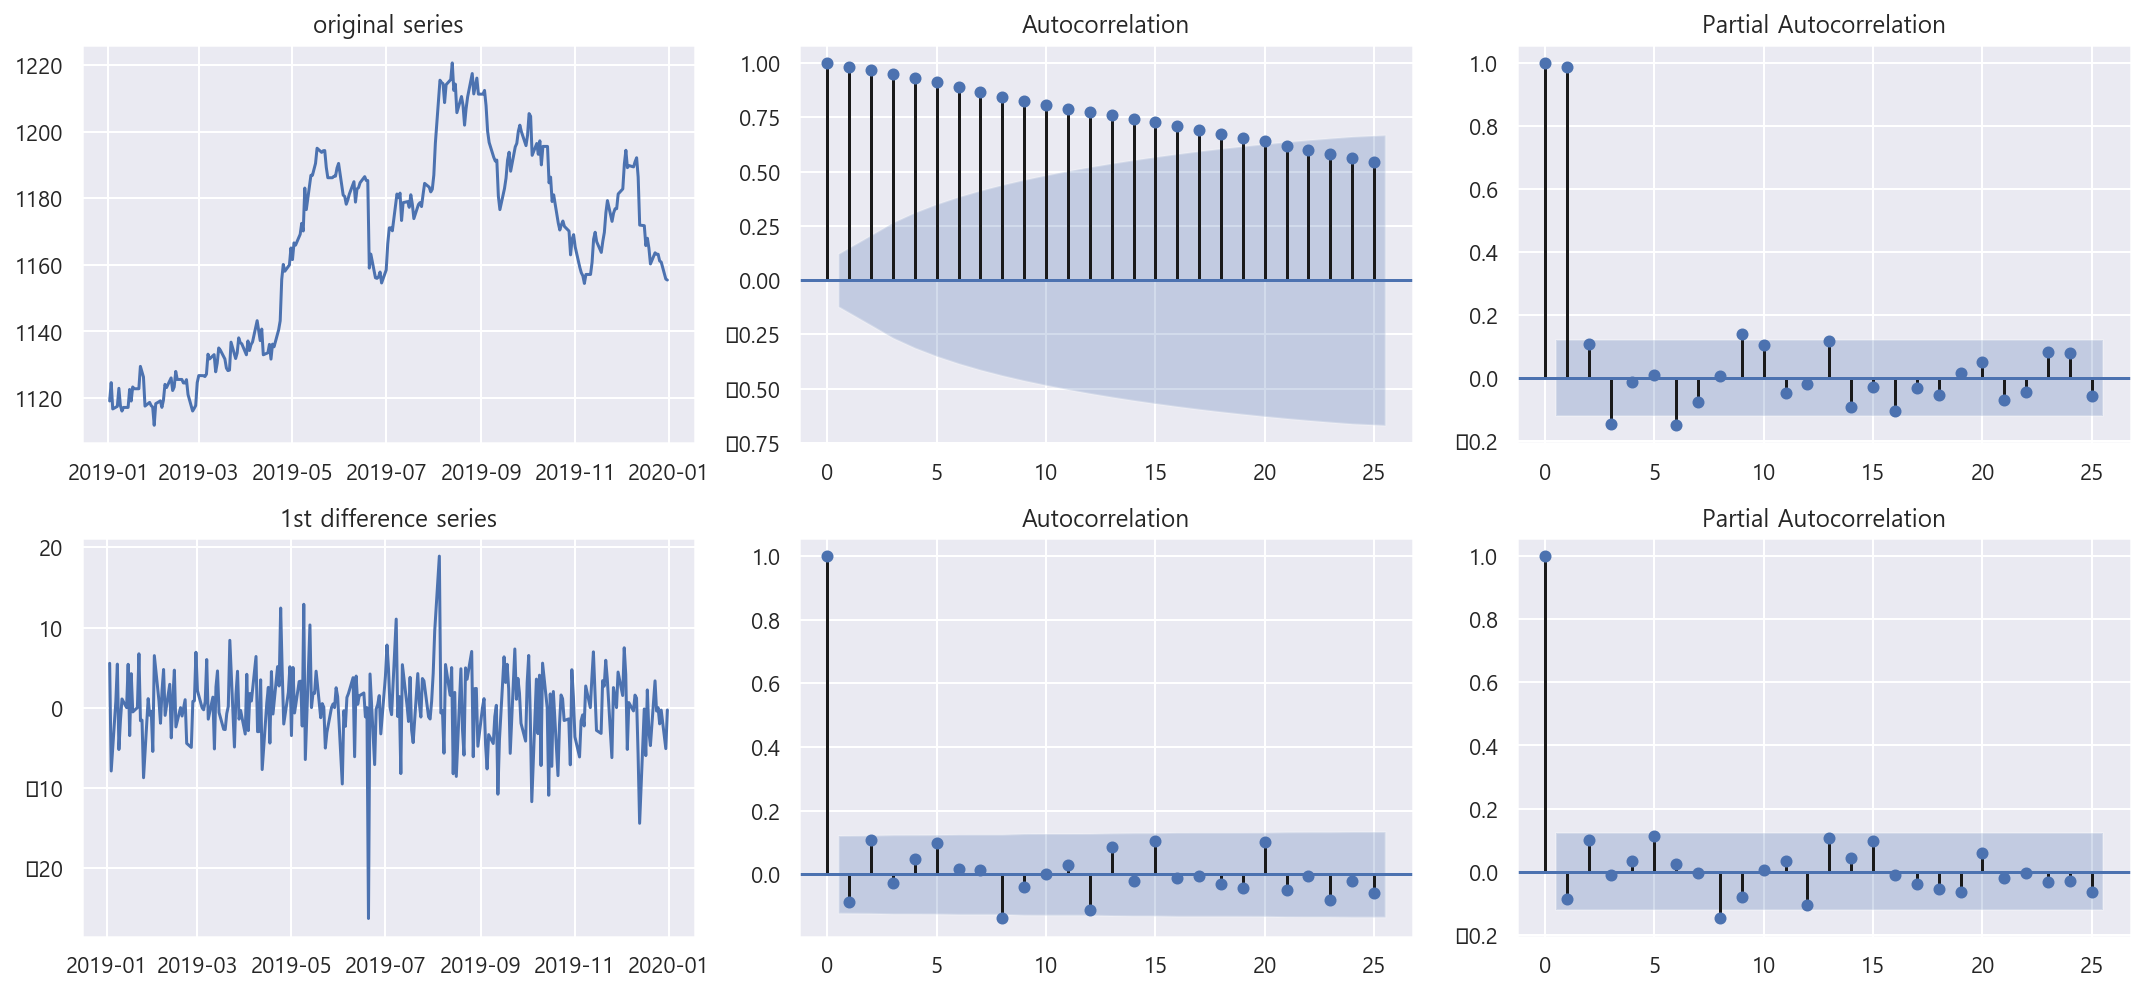

In [17]:
# 2x3 subplot 
figure, axes= plt.subplots(2, 3, figsize=(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original series')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS,axes[0,1])
plot_pacf(df.KOUS,axes[0,2])
plot_acf(df.KOUS.diff().dropna(),axes[1,1])
plot_pacf(df.KOUS.diff().dropna(),axes[1,2])
plt.tight_layout()
plt.show()

In [18]:
# AR차수 3차 or 1차
# MA 차수 2차 or 0차




# ARIMA 예측 모델링


In [20]:
# ARIMA의 차수는 (3,1,2)
model = ARIMA(df.KOUS, order=(3,1,2), freq='B') #freq B는 business day
model_fit = model.fit(trend='nc')
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -768.706
Method:                       css-mle   S.D. of innovations              4.677
Date:                Sun, 26 Jul 2020   AIC                           1549.412
Time:                        20:25:07   BIC                           1570.753
Sample:                    01-03-2019   HQIC                          1557.992
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.2878      0.064     -4.504      0.000      -0.413      -0.163
ar.L2.D.KOUS    -0.9557      0.030    -31.909      0.000      -1.014      -0.897
ar.L3.D.KOUS    -0.0885      0.064     -1.38

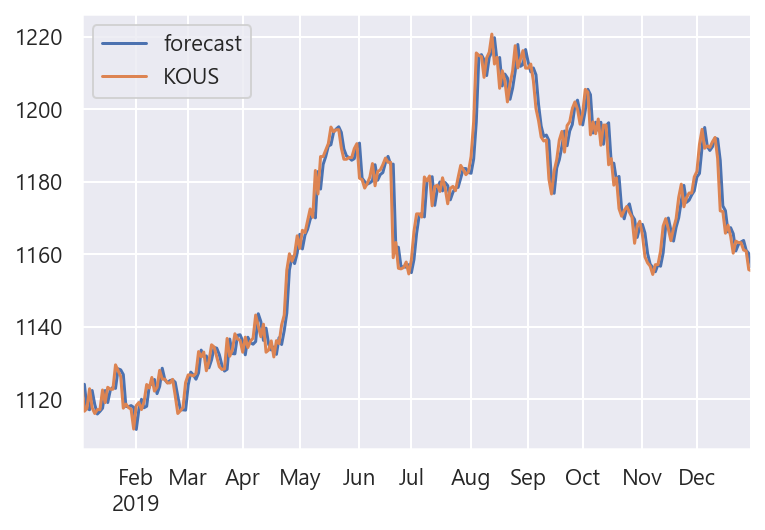

In [21]:
model_fit.plot_predict()
plt.show()

In [24]:
## Training set, Test set을 나누어서 학습과 평가
train=df.iloc[0:30]
test=df.iloc[30:35]



In [25]:
model =  ARIMA(train, order=(2,1,2), freq='B')
model_fit = model.fit(trend='nc')
fc, se, conf = model_fit.forecast(5, alpha=0.05)


In [26]:
fc

array([1122.71125883, 1123.35491852, 1123.72752365, 1123.72485951,
       1123.51271377])

In [31]:
fc_series = pd.Series(fc, index=test.index)
lower_series=pd.Series(conf[:,0], index=test.index)
upper_series=pd.Series(conf[:,1], index=test.index)

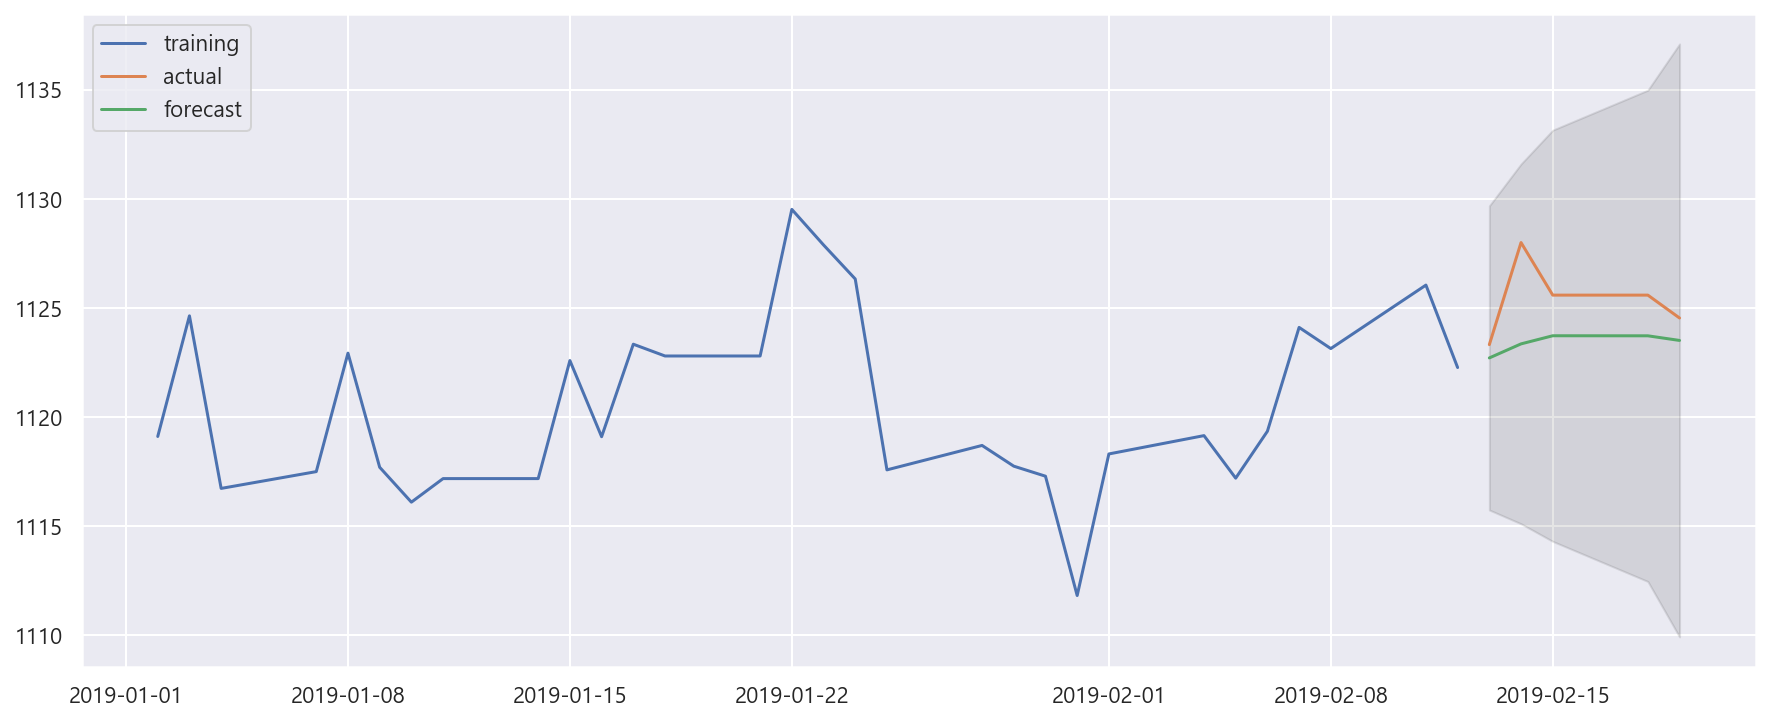

In [35]:
# plot
plt.figure(figsize=(15,6))
plt.plot(train, label='training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='black', alpha=0.1)
plt.legend(loc='upper left')
plt.show()
